<a href="https://colab.research.google.com/github/Anzaliyadav321/LGMVIP-DataScience-Task-Number/blob/main/Task-2%20Next%20Word%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Anjali Yadav**

**Next Word Prediction (Advanced - Level)**

**Import Libraries**

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import heapq
import tensorflow as tf
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

In [56]:
#loading the data
path = '/content/1661-0.txt'
text = open(path, encoding='utf8').read().lower()
print('length of the corpus is: ', len(text))

length of the corpus is:  581888


In [57]:
#using tokenizers
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [58]:
#getting unique words
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

**Feature engineering**

In [59]:
LENGTH_WORD = 5
prev_words = []
next_words = []
for i in range(len(words) - LENGTH_WORD):
  prev_words.append(words[i:i + LENGTH_WORD])
  next_words.append(words[i + LENGTH_WORD])

print(prev_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures']
of


**X storing feature and Y storing Label**

In [60]:
X = np.zeros((len(prev_words), LENGTH_WORD, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [61]:
#single sequence
print(X[0][0])

[False False False ... False False False]


In [62]:
print(Y[0])

[False False False ... False False False]


In [63]:
X.shape

(109221, 5, 8201)

In [64]:
Y.shape

(109221, 8201)

**Building and Training the Model**

In [65]:
model = Sequential()

model.add(LSTM(128, input_shape=(LENGTH_WORD, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01) #model uses RMSprop as the optimizer

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


**Model Summary**

In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               4264960   
                                                                 
 dense_1 (Dense)             (None, 8201)              1057929   
                                                                 
 activation_1 (Activation)   (None, 8201)              0         
                                                                 
Total params: 5,322,889
Trainable params: 5,322,889
Non-trainable params: 0
_________________________________________________________________


**Visualize the Model**

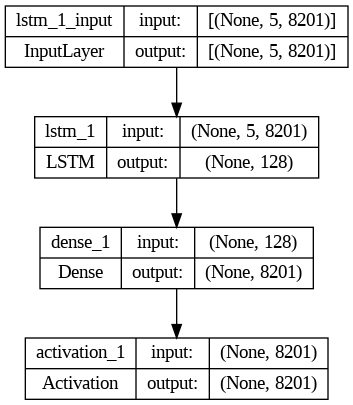

In [67]:

tf.keras.utils.plot_model(
     model,
     show_shapes=True,
     show_layer_names=True,
  )

**Training the Model**

In [68]:
history = model.fit(X, Y, validation_split=0.05, epochs=2, batch_size=128, shuffle=True).history

Epoch 1/2
811/811 [==============================] - 284s 346ms/step - loss: 6.0249 - accuracy: 0.1060 - val_loss: 7.0498 - val_accuracy: 0.1031
Epoch 2/2
811/811 [==============================] - 275s 339ms/step - loss: 5.7847 - accuracy: 0.1478 - val_loss: 7.9818 - val_accuracy: 0.1060


**saving and loading the model**

In [69]:
model.save('next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

**Model evaluation**

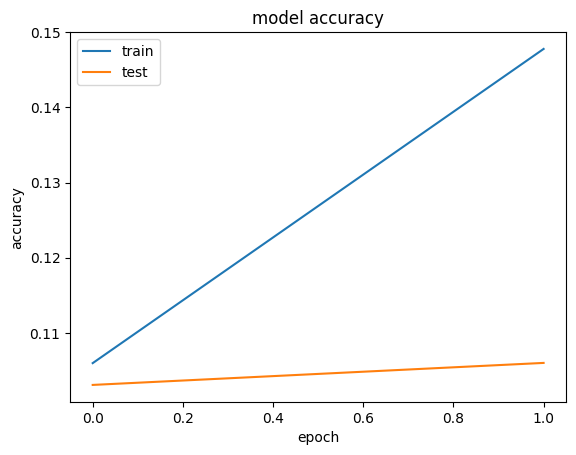

In [70]:
#accuracy plot curve for training and testing
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

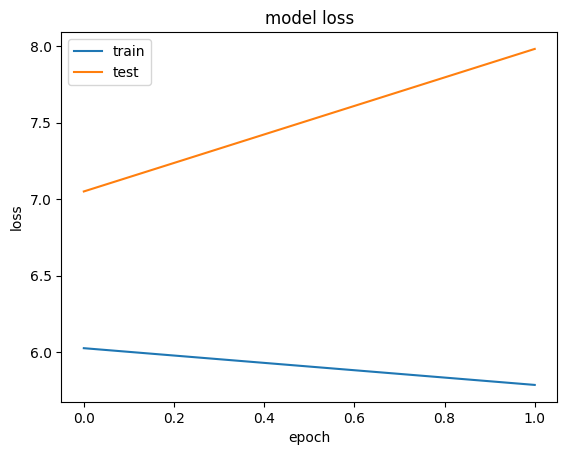

In [71]:
#loss plot curve for training and testing
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

In [72]:
# #performance of training dataset
train_loss, train_acc = model.evaluate(X, Y)
print('Train loss: ', train_loss)
print('Train accuracy; ', train_acc)

In [73]:
# #performance of testing dataset
loss_and_acc = model.evaluate(X,Y)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])


**For Testing next word**

In [74]:
def prepare_input(text):
    x = np.zeros((1, LENGTH_WORD, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("This is for a prediction".lower())

this
is
for
a
prediction


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [75]:
#to choose the best possible n words
def sample(preds, top_n=3):
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds)
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)

  return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [76]:
#function for prediction
def predict_completions(text, n=3):
  if text == "":
    return("0")
  x = prepare_input(text)
  preds = model.predict(x, verbose=0)[0]
  next_indices = sample(preds, n)
  # return [unique_word_index[idx] + predict_completions(text[1:] + unique_word_index[idx]) for idx in next_indices]
  return[unique_words[idx] for idx in next_indices]  

In [77]:
#prediction
quotes = [
    "Keep smiling because life is a beautiful thing and there's so much to smile about.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [78]:
for q in quotes:
    seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
    print(seq)
    print("next possible words: ", predict_completions(seq, 5))
    print()

keep smiling because life is
keep
smiling
because
life
is
next possible words:  ['not', 'the', 'a', 'in', 'all']

i m not upset that
i
m
not
upset
that
next possible words:  ['i', 'he', 'it', 'we', 'you']

and those who were seen
and
those
who
were
seen
next possible words:  ['in', 'the', 'and', 'of', 'were']

it is hard enough to
it
is
hard
enough
to
next possible words:  ['be', 'me', 'know', 'do', 'have']

